In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')

from data_center.binance_handler import BinanceHandHandler
from backtest.performance_generater import *
from backtest.factor_analysis_tool import FactorAnalysisTool
from backtest.operators import *

import alphalens
import quantstats as qs
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [57]:
Open = BinanceHandHandler().get_factor_data('open')
High = BinanceHandHandler().get_factor_data('high')
Low  = BinanceHandHandler().get_factor_data('low')
Close = BinanceHandHandler().get_factor_data('close')
Volume = BinanceHandHandler().get_factor_data('volume')
Volvalue = BinanceHandHandler().get_factor_data('volvalue')
Takerbuy = BinanceHandHandler().get_factor_data('takerbuy')
Takerbuyvalue = BinanceHandHandler().get_factor_data('takerbuyvalue')

returns = Close.pct_change()
expreturn = Close.pct_change().shift(-2)
Benchmark = expreturn['BTCUSDT']

In [58]:
### 將資料太短或可疑資料去除

raw_factor_list = [Open, High, Low, Close, Volume, Volvalue, Takerbuy, Takerbuyvalue, returns, expreturn]

comparison_date = pd.to_datetime('2022-01-01')

columns_to_delete = []

for raw_factor in raw_factor_list:

    # 时间戳检查：删除首个非空条目时间戳大于 comparison_date 的列
    for column in raw_factor.columns:
        if raw_factor[column].dropna().index[0] >= comparison_date:
            columns_to_delete.append(column)

    for column in raw_factor.columns:
        # 计算唯一值占比
        unique_ratio = raw_factor[column].nunique() / len(raw_factor[column])
        if unique_ratio <= 0.35:
            columns_to_delete.append(column)


columns_to_delete = list(set(columns_to_delete))
for raw_factor in raw_factor_list:
    raw_factor.drop(columns=columns_to_delete, inplace=True)

for column in raw_factor_list:
    column.dropna(inplace = True)

In [59]:
# 去除 ETF效應
for raw_factor in raw_factor_list:
    del raw_factor['BTCUSDT']
    del raw_factor['ETHUSDT']

In [61]:
Close

BNBUSDT  AAVEUSDT  AVAXUSDT  ETCUSDT   SOLUSDT  ADAUSDT  LINKUSDT  \
datetime                                                                        
2021-03-03  240.499   396.551   27.2227   11.256   14.0941  1.21399    29.854   
2021-03-04  229.743   374.408   25.7677   11.006   13.0784  1.11288    27.721   
2021-03-05  225.407   367.408   24.2636   10.934   12.5659  1.15845    27.862   
2021-03-06  226.349   388.119   24.9377   11.120   13.0512  1.12936    28.166   
2021-03-07  240.269   414.765   26.7401   11.553   13.8450  1.13081    28.603   
...             ...       ...       ...      ...       ...      ...       ...   
2024-03-25  587.480   127.130   57.8090   32.472  189.1810  0.65730    19.396   
2024-03-26  580.560   130.960   55.8260   32.165  190.6230  0.66560    20.023   
2024-03-27  574.800   125.090   54.1460   31.818  186.4480  0.64860    19.315   
2024-03-28  583.830   127.990   54.6840   32.560  189.8520  0.65170    19.172   
2024-03-29  612.350   127.630   53.3850   34.215  192.2000  0.66500    18.989   

            BCHUSDT  DOTUSDT  LTCUSDT  UNIUSDT  XRPUSDT  XLMUSDT  MATICUSDT  \
datetime                                                                      
2021-03-03   521.45   37.043   187.72  25.3835   0.4486  0.42071    0.22251   
2021-03-04   506.03   35.277   180.82  28.3053   0.4816  0.41233    0.19915   
2021-03-05   497.48   33.640   180.36  28.3138   0.4551  0.40550    0.21299   
2021-03-06   500.93   33.395   182.99  28.5264   0.4630  0.40200    0.21257   
2021-03-07   517.17   35.132   190.96  34.2945   0.4660  0.41300    0.21238   
...             ...      ...      ...      ...      ...      ...        ...   
2024-03-25   487.76    9.746    90.64  12.4360   0.6408  0.13679    1.04670   
2024-03-26   479.72    9.694    95.87  12.7070   0.6323  0.13833    1.04670   
2024-03-27   539.46    9.457    93.65  12.2620   0.6123  0.13392    1.00950   
2024-03-28   568.22    9.533    94.20  12.7670   0.6252  0.13812    1.00320   
2024-03-29   621.24    9.611   109.14  12.6540   0.6308  0.14288    0.99170   

            TRXUSDT  DOGEUSDT  DASHUSDT  XEMUSDT  ZECUSDT  
datetime                                                   
2021-03-03  0.04878  0.050425    222.90   0.7904   126.77  
2021-03-04  0.05139  0.049999    211.43   0.7051   122.24  
2021-03-05  0.05012  0.049530    205.86   0.7157   121.31  
2021-03-06  0.05008  0.050930    208.90   0.7324   125.27  
2021-03-07  0.05167  0.052056    215.02   0.7156   130.26  
...             ...       ...       ...      ...      ...  
2024-03-25  0.12049  0.175390     38.06   0.0518    30.36  
2024-03-26  0.12090  0.182450     38.85   0.0545    31.67  
2024-03-27  0.11950  0.190700     37.95   0.0520    31.05  
2024-03-28  0.12059  0.220220     38.37   0.0528    30.84  
2024-03-29  0.12005  0.213190     39.87   0.0521    30.75  

[1123 rows x 19 columns]

In [60]:
period = 21
rolling_returns = returns.rolling(window = period).mean()
rolling_std_dev = returns.rolling(window = period).std()
sharpe_factor = rolling_returns / rolling_std_dev
sharpe_factor = sharpe_factor.dropna()
sharpe_returns_by_period, _ = PerformanceGenerator(factor = sharpe_factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-25',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()
FactorAnalysisTool(factor = sharpe_factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0,#0.04/100,
                                            sell_fee = 0,#0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-25',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).quantile_analysis(5)

starttime: 2021-03-24 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       131.38 %        |       93.27 %        |     1.03     |    21.23 %     |   22.84 %    |  20.80 %   | 1.31 % | 32.71 %  |
|  Benchmark  |        35.47 %        |       87.77 %        |     0.39     |     7.22 %     |   76.67 %    |  51.25 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### Momentum Factor

In [6]:
sum_ret_factor = returns.rolling(window=20).sum().dropna()
factor = sum_ret_factor
sum_ret_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-25',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()
FactorAnalysisTool(factor = factor, 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,#.04/100,
                    sell_fee = 0,#.04/100,
                    start_time = '2020-01-01',
                    end_time = '2024-03-25',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

starttime: 2021-03-23 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       221.59 %        |       131.39 %       |     1.16     |    30.71 %     |   26.39 %    |  25.99 %   | 1.64 % | 30.32 %  |
|  Benchmark  |        32.92 %        |       85.88 %        |     0.38     |     6.74 %     |   76.67 %    |  51.23 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### 價量背離因子

In [7]:
pv_factor = ts_corr(returns,Volume,30)
factor = pv_factor 
pv_returns_by_period, _ = PerformanceGenerator(factor = factor , 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-25',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

FactorAnalysisTool(factor = factor , 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,
                    sell_fee = 0,
                    start_time = '2020-01-01',
                    end_time = '2024-03-25',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

starttime: 2021-03-03 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |        95.58 %        |       75.78 %        |     0.86     |    16.31 %     |   23.56 %    |  19.87 %   | 1.25 % | 22.04 %  |
|  Benchmark  |        43.70 %        |       94.84 %        |     0.42     |     8.51 %     |   76.67 %    |  51.28 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### Factor_bias

In [8]:
bias_factor = ts_bias(df = Close, d = 27, method='sma')
factor = bias_factor 
bias_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-25',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

FactorAnalysisTool(factor = factor, 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,
                    sell_fee = 0,
                    start_time = '2020-01-01',
                    end_time = '2024-03-25',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

starttime: 2021-03-03 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       163.65 %        |       115.28 %       |     0.90     |    24.40 %     |   29.17 %    |  28.98 %   | 1.83 % | 31.01 %  |
|  Benchmark  |        43.70 %        |       94.84 %        |     0.42     |     8.51 %     |   76.67 %    |  51.28 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### factor CMO

In [9]:
cmo_factor = ts_cmo(Close, 20)
factor = cmo_factor.dropna() 
cmo_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-25',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

FactorAnalysisTool(factor = factor, 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,
                    sell_fee = 0,
                    start_time = '2020-01-01',
                    end_time = '2024-03-25',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

starttime: 2021-03-23 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       181.75 %        |       114.13 %       |     1.18     |    26.81 %     |   22.36 %    |  22.09 %   | 1.39 % | 34.40 %  |
|  Benchmark  |        32.92 %        |       85.88 %        |     0.38     |     6.74 %     |   76.67 %    |  51.23 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


### Factor COPP

In [10]:
copp_factor = ts_copp(Close, roc1_period=15, roc2_period=15, wma_period=15)
factor = copp_factor.dropna()

# 进行回测，这里假设 PerformanceGenerator 和 get_returns_by_period 已经定义
copp_returns_by_period, _ = PerformanceGenerator(factor=factor, 
                                            expreturn=expreturn,
                                            strategy='LS',
                                            buy_fee=0.04/100,
                                            sell_fee=0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-25',
                                            period_of_year=365,
                                            benchmark=Benchmark).backtest()

starttime: 2021-04-01 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       126.63 %        |       93.70 %        |     0.92     |    20.82 %     |   23.47 %    |  23.56 %   | 1.48 % | 12.42 %  |
|  Benchmark  |        17.79 %        |       73.45 %        |     0.33     |     3.86 %     |   76.67 %    |  51.28 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


In [11]:
df = pd.concat([sharpe_returns_by_period, sum_ret_returns_by_period, pv_returns_by_period, bias_returns_by_period, cmo_returns_by_period, copp_returns_by_period, Benchmark], axis=1).dropna()
df.columns = ['sharpe', 'sum_ret', 'PV', 'bias', 'cmo', 'copp', 'BTC']

# 计算相关系数
correlation_matrix = df.corr()

print(correlation_matrix)

           sharpe   sum_ret        PV      bias       cmo      copp       BTC
sharpe   1.000000  0.894741  0.581136  0.835852  0.945338  0.694142 -0.034682
sum_ret  0.894741  1.000000  0.654438  0.927154  0.912979  0.721865 -0.016124
PV       0.581136  0.654438  1.000000  0.658790  0.666241  0.434013 -0.004410
bias     0.835852  0.927154  0.658790  1.000000  0.893138  0.523835 -0.062684
cmo      0.945338  0.912979  0.666241  0.893138  1.000000  0.601760 -0.050435
copp     0.694142  0.721865  0.434013  0.523835  0.601760  1.000000 -0.000377
BTC     -0.034682 -0.016124 -0.004410 -0.062684 -0.050435 -0.000377  1.000000


In [12]:
Multi_alpha = sharpe_factor + sum_ret_factor + bias_factor + cmo_factor + copp_factor + pv_factor

factor = Multi_alpha.dropna()
Multi_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                                expreturn = expreturn,
                                                strategy = 'LS',
                                                buy_fee = 0.04/100,
                                                sell_fee = 0.04/100,
                                                start_time = '2020-01-01',
                                                end_time = '2024-03-25',
                                                period_of_year = 365,
                                                benchmark = Benchmark
                                                ).backtest()


FactorAnalysisTool(factor = factor, 
                    expreturn = expreturn,
                    strategy = 'LS',
                    buy_fee = 0,
                    sell_fee = 0,
                    start_time = '2020-01-01',
                    end_time = '2024-03-25',
                    period_of_year = 365,
                    benchmark = Benchmark
                    ).quantile_analysis(5)

starttime: 2021-04-02 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       175.83 %        |       114.32 %       |     1.08     |    26.46 %     |   23.84 %    |  24.52 %   | 1.54 % | 21.24 %  |
|  Benchmark  |        21.70 %        |       76.66 %        |     0.35     |     4.65 %     |   76.67 %    |  51.28 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


Quantile 5 represents the highest factor value


In [67]:
Multi_alpha.columns.to_list()

['BNBUSDT',
 'AAVEUSDT',
 'AVAXUSDT',
 'ETCUSDT',
 'SOLUSDT',
 'ADAUSDT',
 'LINKUSDT',
 'BCHUSDT',
 'DOTUSDT',
 'LTCUSDT',
 'UNIUSDT',
 'XRPUSDT',
 'XLMUSDT',
 'MATICUSDT',
 'TRXUSDT',
 'DOGEUSDT',
 'DASHUSDT',
 'XEMUSDT',
 'ZECUSDT']

In [63]:
Multi_alpha = sharpe_factor + sum_ret_factor + bias_factor + cmo_factor # + copp_factor + pv_factor
ranked_df = Multi_alpha.dropna().rank(axis=1, pct=True)

# Replace values between 0.2 and 0.8 with NaN
filtered_df = ranked_df.where(~((ranked_df > 0.2) & (ranked_df < 0.8)), np.nan)
factor = filtered_df

Multi_quantile_returns_by_period, _ = PerformanceGenerator(factor = factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-25',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

starttime: 2021-03-29 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       267.06 %        |       145.18 %       |     1.27     |    34.96 %     |   23.32 %    |  26.44 %   | 1.67 % |  5.20 %  |
|  Benchmark  |        18.26 %        |       73.85 %        |     0.33     |     3.94 %     |   76.67 %    |  51.21 %   | 3.23 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


In [51]:
import pandas as pd
from scipy.stats import spearmanr
from scipy import stats

factor_df = Multi_alpha

# 计算每个日期的IC值
def calculate_ic(factor_df, returns_df):
    ic_series = pd.Series(index=factor_df.index)
    for date in factor_df.index:
        # 检查日期是否存在于returns_df中
        if date in returns_df.index:
            factor_values = factor_df.loc[date]
            return_values = returns_df.loc[date]
            # 仅考虑两个数据框都有数据的股票
            valid_index = factor_values.dropna().index.intersection(return_values.dropna().index)
            if not valid_index.empty:
                ic, _ = spearmanr(factor_values[valid_index], return_values[valid_index])
                ic_series[date] = ic
    return ic_series

ic_series = calculate_ic(factor_df, expreturn)

In [52]:
ic_mean = ic_series.mean()
print("Mean IC:", ic_mean)

ir = ic_series.mean() / ic_series.std()
print("IR:", ir)

n = ic_series.count()  # 有效IC值的数量
mean_ic = ic_series.mean()
std_ic = ic_series.std()
stderr = std_ic / (n ** 0.5)
t_stat = mean_ic / stderr
p_value = stats.t.sf(abs(t_stat), df=n-1)*2  # 双尾检验
print('T stat:', t_stat )
print('p value:', p_value)

Mean IC: -0.027028541128849923
IR: -0.09801042326100752
T stat: -3.243241767004585
p value: 0.001217503012520064


In [42]:
print('BTC:', Benchmark.std())
print('Multi:', Multi_returns_by_period.std())
print('Multi_quantile:', Multi_quantile_returns_by_period.std())


BTC: 0.03515343053434822
Multi: 0.015448450942518939
Multi_quantile: 0.016658383248385256


### 給ARAS

In [53]:
import pandas as pd
import matplotlib.pyplot as plt



profolio_manipulate = Multi_quantile_returns_by_period*.7 + Benchmark*.3

summary_df = get_performance_report(profolio_manipulate, benchmark=Benchmark, period_of_year=365)

starttime: 2021-03-29 00:00:00 endtime:  2024-03-25 00:00:00
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+
| Performance |       206.34 %        |       123.78 %       |     1.47     |    45.33 %     |   25.43 %    |  28.11 %   | 1.47 % |
|  Benchmark  |        18.26 %        |       73.85 %        |     0.40     |     5.76 %     |   76.67 %    |  61.64 %   | 3.23 % |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+


/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to n

Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min         max       mean        std  count  \
factor_quantile                                                        
1               -117.423546   82.245938 -27.484034  33.628794   4092   
2               -103.807491   91.000058 -13.311859  33.769975   4092   
3                -97.378762   96.244070  -4.754341  34.481677   3069   
4                -91.137233  116.171702   5.104328  35.628569   4092   
5                -79.992895  246.034666  30.415471  42.494655   4092   

                   count %  
factor_quantile             
1                21.052632  
2                21.052632  
3                15.789474  
4                21.052632  
5                21.052632

Returns Analysis


1D     5D    10D
Ann. alpha                                      0.163  0.119  0.129
beta                                           -0.016 -0.039 -0.009
Mean Period Wise Return Top Quantile (bps)      7.955  4.509  5.066
Mean Period Wise Return Bottom Quantile (bps)  -3.326 -3.349 -5.577
Mean Period Wise Spread (bps)                  11.281  7.099  9.863

<Figure size 1000x600 with 0 Axes>

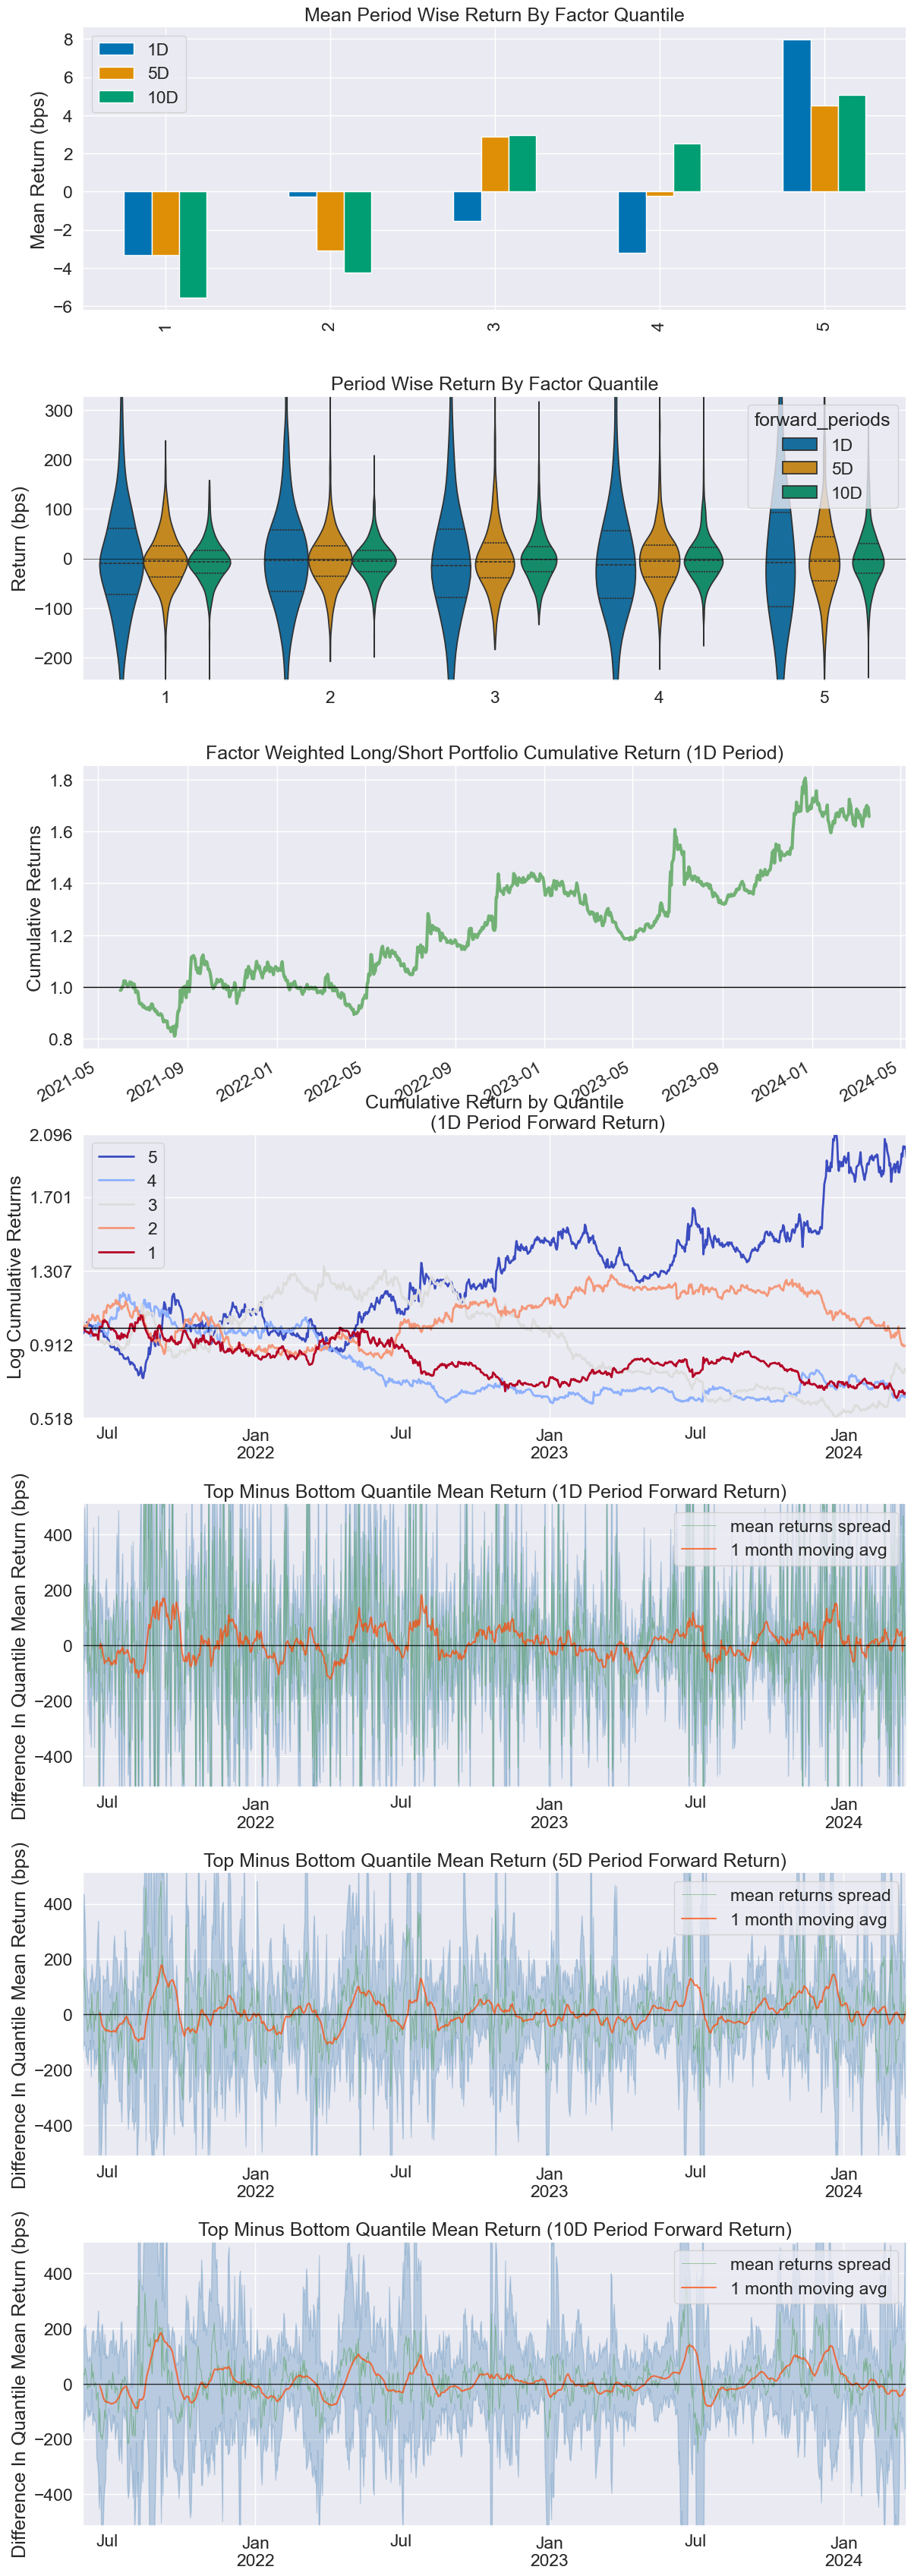

Information Analysis


1D     5D    10D
IC Mean          -0.031 -0.031 -0.013
IC Std.           0.276  0.272  0.266
Risk-Adjusted IC -0.111 -0.115 -0.047
t-stat(IC)       -3.555 -3.676 -1.509
p-value(IC)       0.000  0.000  0.132
IC Skew           0.016  0.045 -0.012
IC Kurtosis      -0.293 -0.353 -0.442

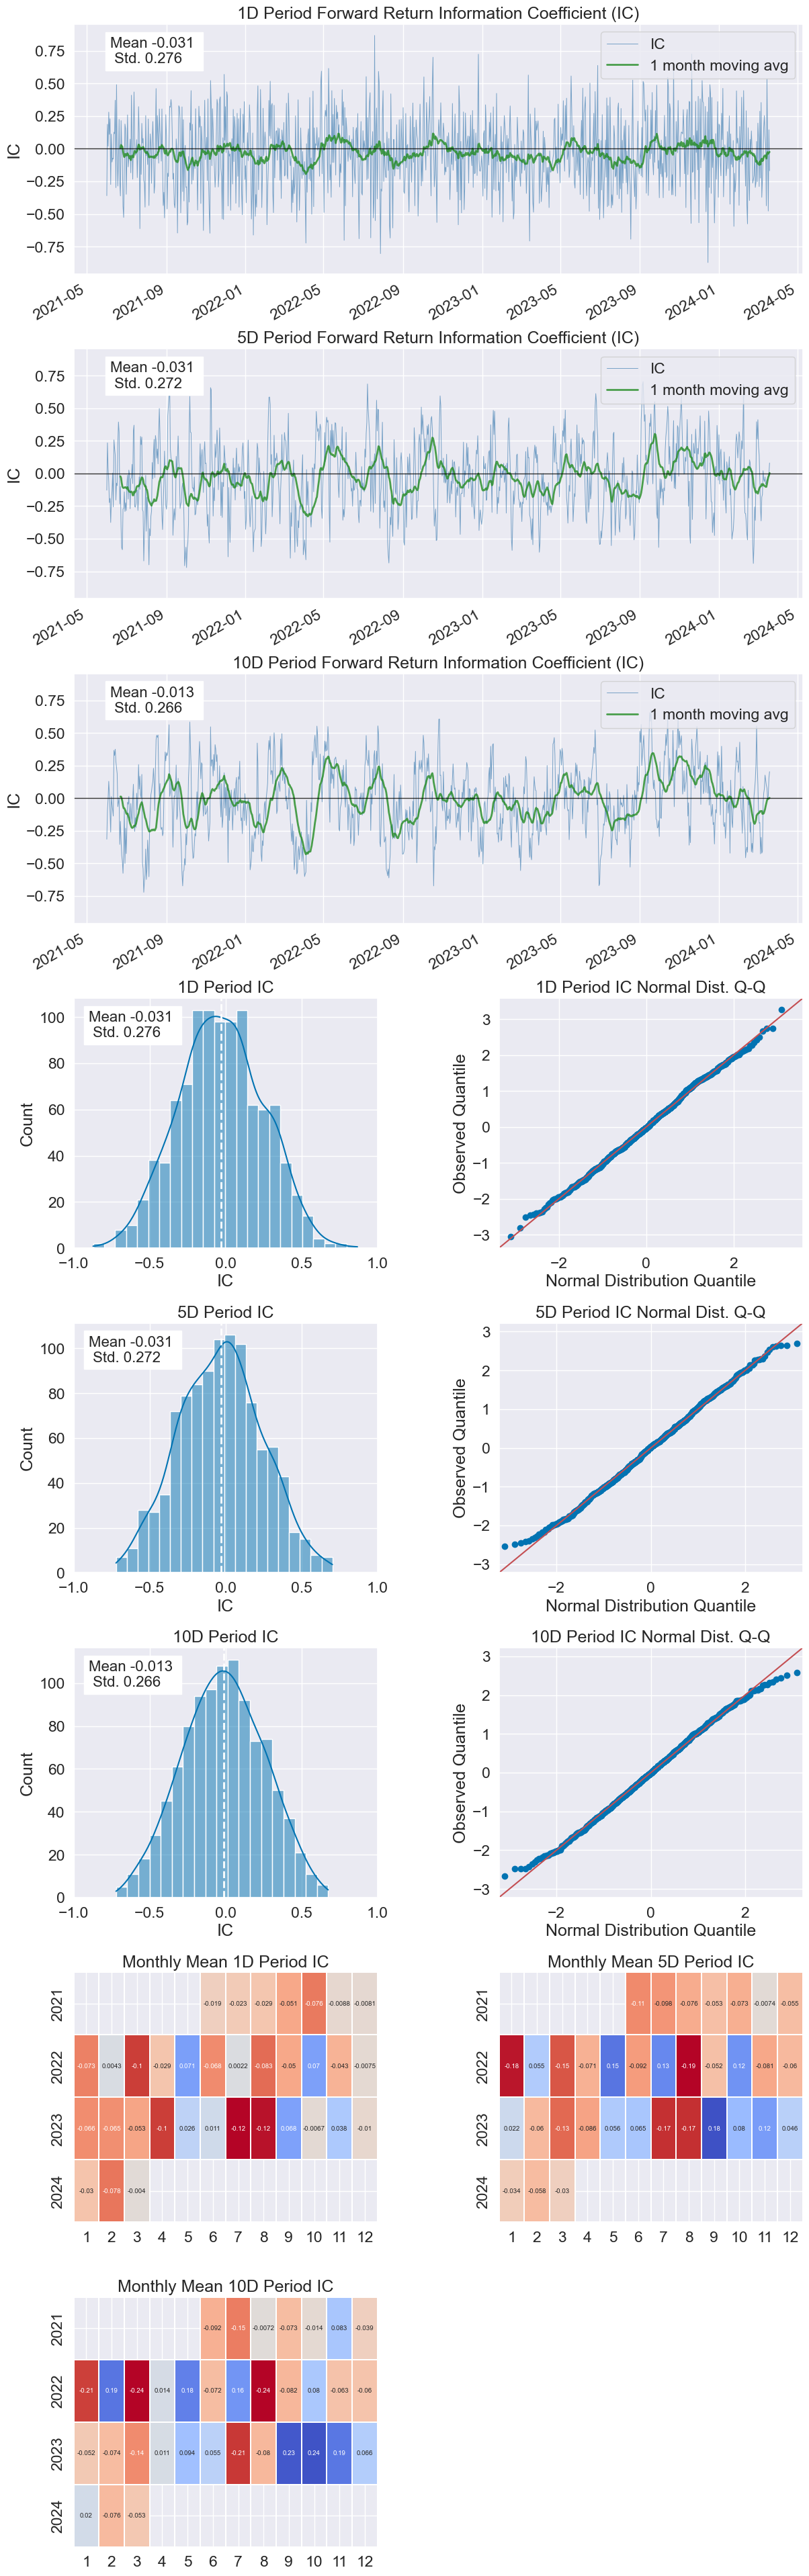

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:929: UserWarning:

Skipping return periods that aren't exact multiples of days.



Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.211  0.443  0.591
Quantile 2 Mean Turnover   0.417  0.660  0.715
Quantile 3 Mean Turnover   0.546  0.755  0.808
Quantile 4 Mean Turnover   0.386  0.632  0.722
Quantile 5 Mean Turnover   0.172  0.371  0.521

1D     5D    10D
Mean Factor Rank Autocorrelation  0.912  0.677  0.438

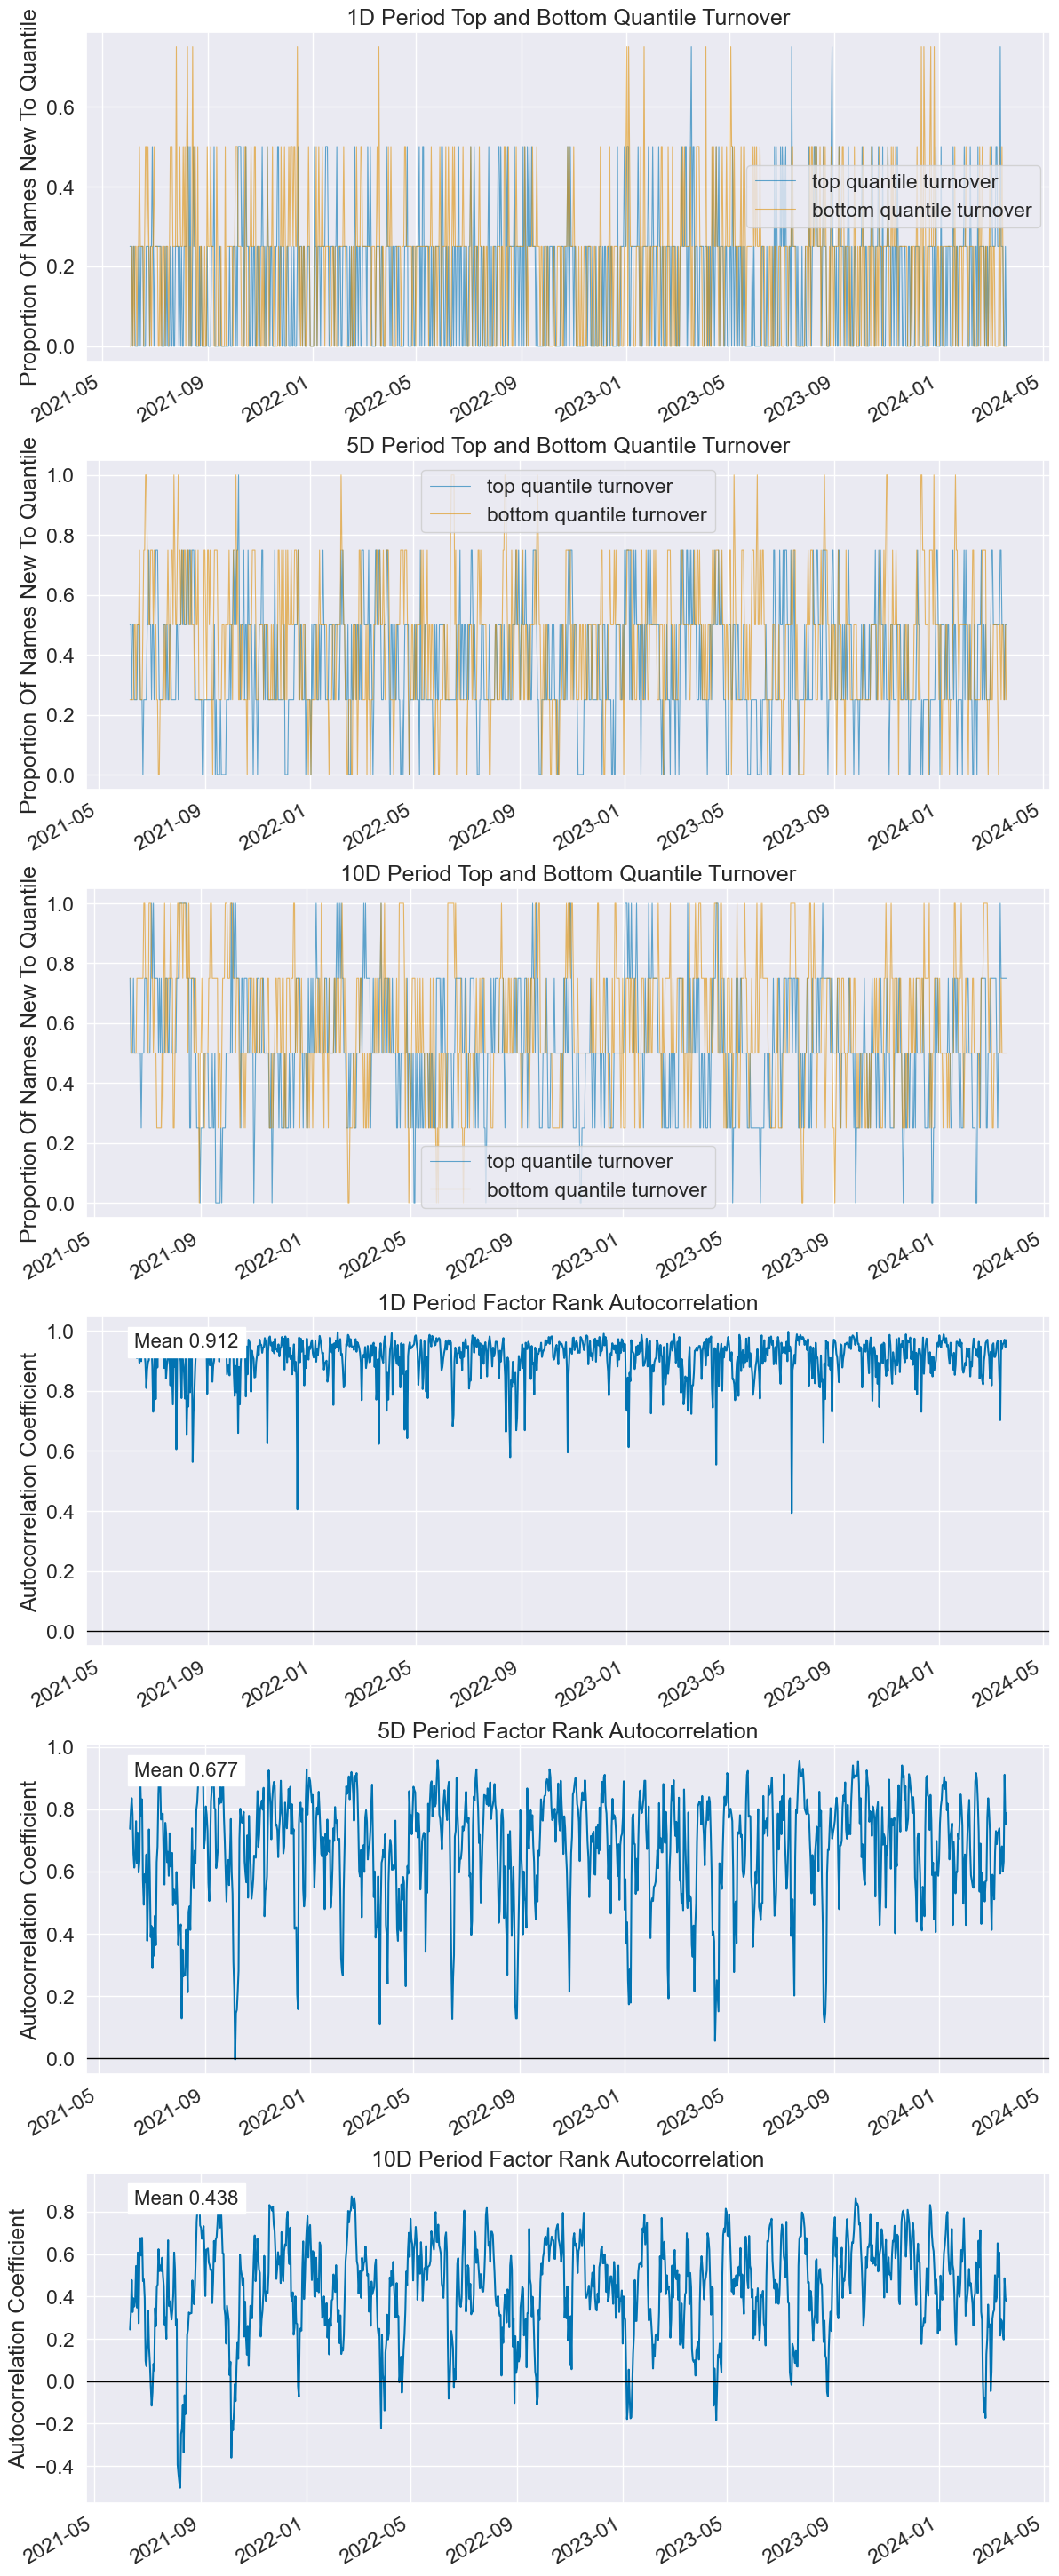

In [65]:
factor = Multi_alpha['2021-06-01':].unstack().swaplevel(i=0, j=1)

factor_daily = factor.sort_index()

close_daily = Close.shift(-1)

# Ingest and format data
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_daily,
                                                                   close_daily,
                                                                   quantiles=5)

# Run analysis
alphalens.tears.create_full_tear_sheet(factor_data)